### Step 1: Define a mini batch of 2D embeddings (4 samples)

### Step 2: Define 2 cluster centers (2D)

In [ ]:
# DEC-style Soft Assignment: Minimal Example

import numpy as np
import pandas as pd


batch = np.array([
    [1.0, 2.0],
    [2.0, 1.0],
    [8.0, 8.0],
    [9.0, 9.0]
])  # Shape: (4, 2) --> [num_samples, hidden_layer]


cluster_centers = np.array([
    [1.0, 1.0],
    [9.0, 8.0]
])  # Shape: (2, 2) --> [num_clusters, hidden_layer]



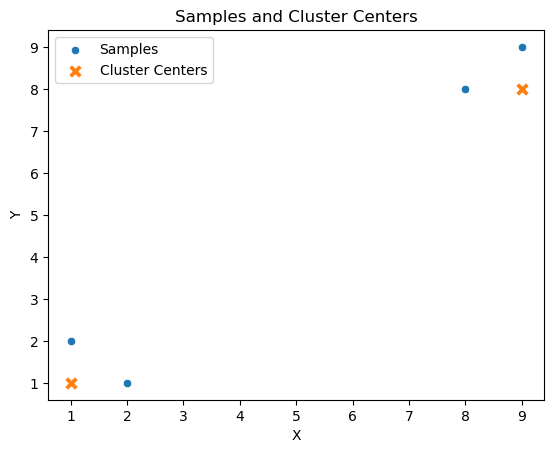

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=batch[:, 0], y=batch[:, 1], label='Samples')
sns.scatterplot(x=cluster_centers[:, 0], y=cluster_centers[:, 1], label='Cluster Centers', marker='X', s=100)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples and Cluster Centers')
plt.show()

### Step 3: Compute squared Euclidean distance between each point and each cluster

In [ ]:
# Shape explanation:
#   batch.unsqueeze(1): (4, 1, 2)
#   cluster_centers: (2, 2) → broadcasted to (1, 2, 2)
#   Result: (4, 2, 2) → Sum over dim=2 → (4, 2)


print(f"First data point - 2nd cluster:\n{batch[:, np.newaxis, :][0]} - {cluster_centers[1]} = {batch[:, np.newaxis, :][0] - cluster_centers[1]}")
print(f"\npower of 2: {(batch[:, np.newaxis, :][0] - cluster_centers[1])**2}\n")
norm_squared = np.sum((batch[:, np.newaxis, :] - cluster_centers) ** 2, axis=2)
print(f"Sum[1]: {norm_squared[0][1]}\n")

# ----------------------------------------------
print("Squared distances (all SUM's):\n", norm_squared)

First data point - 2nd cluster:
[[1. 2.]] - [9. 8.] = [[-8. -6.]]

power of 2: [[64. 36.]]

Sum[1]: 100.0

Squared distances (all SUM's):
 [[  1. 100.]
 [  1.  98.]
 [ 98.   1.]
 [128.   1.]]


### Step 4: Apply the Student's t-distribution kernel

In [37]:
alpha = 1.0  # Distribution parameter (sharper vs flatter assignments)

numerator = 1.0 / (1.0 + norm_squared / alpha)
print(f"Numerator (alpha=1): \n{numerator}")


Numerator (alpha=1): 
[[0.5        0.00990099]
 [0.5        0.01010101]
 [0.01010101 0.5       ]
 [0.00775194 0.5       ]]


In [ ]:
power = (alpha + 1.0) / 2
numerator = numerator ** power # alpha == 1, nothing changes

print(f"Numerator (alpha=1): \n{numerator}")

Numerator (alpha=1): 
[[0.5        0.00990099]
 [0.5        0.01010101]
 [0.01010101 0.5       ]
 [0.00775194 0.5       ]]


### Step 5: Normalize across clusters (dim=1)

In [43]:
sum = np.sum(numerator, axis=1, keepdims=True)

print(f"Sum per line: \n{sum}")

soft_assignments = numerator / sum

print("\nSoft assignments (probabilities):\n", soft_assignments)

Sum per line: 
[[0.50990099]
 [0.51010101]
 [0.51010101]
 [0.50775194]]

Soft assignments (probabilities):
 [[0.98058252 0.01941748]
 [0.98019802 0.01980198]
 [0.01980198 0.98019802]
 [0.01526718 0.98473282]]


In [44]:
# Optional: convert to DataFrame for readability
df = pd.DataFrame(soft_assignments, columns=["Cluster 0", "Cluster 1"])
df.index.name = "Sample"
print("\nAssignment Table:\n", df)


Assignment Table:
         Cluster 0  Cluster 1
Sample                      
0        0.980583   0.019417
1        0.980198   0.019802
2        0.019802   0.980198
3        0.015267   0.984733
